In [33]:
import mne 
from glob import glob 
import os
import matplotlib 
import matplotlib.pyplot as plt
from openpyxl import load_workbook
import numpy as np

In [34]:
#matplotlib.use('Qt5Agg') 

In [35]:
#quanti soggetti ho nella mia cartella?
subs_file_path=glob("..\..\DATASET PRINCIPALE\CartellaEEG/*.vhdr")
print(len(subs_file_path))

#creo vettore file excel---- !ATTENZIONE FAR RUNNARE IL FILE EXCEL.YPTR per aggiustare gli excel
excel_file_path=glob("..\..\DATASET PRINCIPALE\Cartellaexcel/*.xlsx")
print(len(excel_file_path))

4
4


In [36]:
#Creo la funzione che legge e processa i dati 
def prep_data(file_path):
    data= mne.io.read_raw_brainvision(file_path, preload=True)
    data.set_eeg_reference();
    data.notch_filter(np.arange(50,100,50), filter_length='auto',phase='zero')
    data.notch_filter(np.arange(20,40,20), filter_length='auto',phase='zero')
    data.notch_filter(np.arange(10,20,10), filter_length='auto',phase='zero')
    data.filter(l_freq=0.1,h_freq=100)
    data.resample(250)
    return data

#Creo la funzione che estrae la matrice delle annotazioni dai file excel 
def get_vectors(data_path):

    book=load_workbook(data_path)
    sheet=book.active
    
    #onset
    onset=[]
    for row in sheet['a2':'a22249']:
        for cel in row:
               onset.append(cel.value)
                
    onset=np.array(onset)
    onset=onset*0.001
    
    #duration 
    duration=np.ones((22248,), dtype=int)*0.01
    
    #description 
    animal=['animal']
    human=['human']
    description=[]
    for row in sheet ['e2':'e22249']:
        for cel in row:
            if(cel.value in animal):
                description.append(cel.value)
            elif(cel.value in human):
                description.append(cel.value)
            else:
                description.append('E 1')
    return [onset, duration, description] 

#creo la funzione che applica le annotazioni 
def fix_events(data_vector, matrix):
    myannot=[mne.Annotations(onset=matrix[i][0], duration=matrix[i][1],description=matrix[i][2])for i in range(len(excel_file_path))]
    for i in range(len(excel_file_path)):
        data_vector[i].set_annotations(myannot[i])
    
    return data_vector

#creo la funzione che estrae le epochs
def get_epochs(data_vector):
    tmin=-0.100 #partono 100 millisecondi prima di un evento 
    tmax=1 #finiscon 1000 milli secondo dopo 
    baseline=(None,0)
    epochs=[mne.Epochs(i,events=mne.events_from_annotations(i)[0],tmin=tmin,tmax=tmax,baseline=baseline, preload=True)for  i in data_vector]
   
    for i in range(len(data_vector)):
        #reject  bad epochs
        reject_criteria = dict(eeg=150e-6)
        flat_criteria = dict(eeg=1e-6)
        epochs[i].drop_bad(reject=reject_criteria, flat=flat_criteria)
        
    return epochs 

In [37]:
#funzione preprocessing
prep_data_sub_vector= [prep_data(i)for i in subs_file_path]

Extracting parameters from ..\..\DATASET PRINCIPALE\CartellaEEG\sub-01_task-rsvp_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 3035739  =      0.000 ...  3035.739 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 6601 samples (6.601 sec)

Setting up band-stop filter from 19 - 21 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firw

Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 19.45
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 19.20 Hz)
- Upper passband edge: 20.55 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 20.80 Hz)
- Filter length: 6601 samples (6.601 sec)

Setting up band-stop filter from 9.5 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.47
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 9.22 Hz)
- Upper passband edge: 10.53 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 10.78 Hz)
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
S

In [38]:
#estraggo la matrice delle annotazioni 
matrix=[]
for i in range(len(excel_file_path)):
    matrix=[get_vectors(i)for i in excel_file_path]

In [39]:
#sistemo gli eventi 
data_vector_ok= fix_events(prep_data_sub_vector, matrix)

In [40]:
#ICA
#applico la ica per visualizzare i picchi di potenza da rimuovere
ica = mne.preprocessing.ICA(n_components=30, max_iter=1000,random_state=0)
for i in range(len(data_vector_ok)):
    ica.fit(data_vector_ok[i].filter(0.1, 35))
    bad_idx, scores=ica.find_bads_eog(data_vector_ok[i],ch_name=['Fp1','Fp2'],threshold=1)
    ica.exclude=bad_idx
    data_vector_ok[i]=ica.apply(data_vector_ok[i], exclude=ica.exclude)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 8251 samples (33.004 sec)

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 67.8s.
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- L

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 sec)

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 19 ICA components
    Projecting back using 63 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequen

In [41]:
#vettore di epochs, uno spazio per ogni soggetto
epochs_vector=get_epochs(data_vector_ok)

Used Annotations descriptions: ['E 1', 'animal', 'human']
Not setting metadata
Not setting metadata
22248 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 22248 events and 276 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['E 1', 'animal', 'human']
Not setting metadata
Not setting metadata
22248 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 22248 events and 276 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['E 1', 'animal', 'human']
Not setting metadata
Not setting metadata
22248 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 22248 events and 276 original time points ...
0 bad epochs dropped
Used Annotations

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch 

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
   

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on E

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based 

    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on E

    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
 

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']

    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1

    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : 

    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'TP10', 'Fp2', 'AF7', 'AF3', 'F5']
    Rejecting  epoch based on EEG : ['Fp1', 'TP10', 'Fp2', 'AF7', 'AF3', 'F5', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
 

    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']

    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['

    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Reje

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
   

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    R

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', '

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF

    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch b

    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Reje

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']

    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7'

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejectin

    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Reje

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Reject

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch bas

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  e

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejectin

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Reject

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : 

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', '

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch base

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF8', 'AF4']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : 

    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based

    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rej

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
   

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'F5', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'F5', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'F5', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'F5', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'F5', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'F5', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
   

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Re

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  

    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  

    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on E

    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
    Rejecting  epoc

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7']
   

    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FC2', 'AF7', 'AFz', 'F1', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FC2', 'AF7', 'AFz', 'F1', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FC2', 'AF7', 'AFz', 'F1', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FC2', 'AF7', 'AFz', 'F1', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FC2', 'AF7', 'AFz', 'F1', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FC2', 'AF7', 'F1', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FT9', 'FC5', 'FC1', 'O1', 'Oz', 'FT10', 'FC2', 'AF7', 'AFz', 'F1', 'F5', 'FT7', 'C1', 'C5', 'TP7', 'PO4', 'PO8', 'CPz', 'FT8', 'F2', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FT9', 'FC5', 'FC1', 'T7', 'O1', 'Oz', 'FT10', 'FC2', 'AF7', 'AFz', 'F1', 'F5', 'FT7', 'C1', 'C5', 'TP7', 'PO4', 'PO8', 'CPz', 'FT8', 'F2', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'FC5', 'FC1', 'T7', 'O1', 'Oz', 'FT10', 'FC2', 'AFz', 'F1', 'F5'

    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['F5', 'TP7']
    Rejecting  epoch based on EEG : ['F5', 'TP7']
    Rejecting  epoch based on EEG : ['F5', 'TP7']
    Rejecting  epoch based on EEG : ['F5', 'TP7']
    Rejecting  epoch based on EEG : ['F5', 'TP7']
    Rejecting  epoch based on EEG : ['F5', 'TP7']
    Rejecting  epoch based on EEG : ['F5', 'TP7']
    Rejecting  epoch based on EEG 

    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FT9', 'FC5', 'FC1', 'T7', 'TP9', 'CP5', 'CP2', 'T8', 'FT10', 'FC6', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'POz', 'PO4', 'CPz', 'FC4', 'FT8', 'F6', 'F2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FT9', 'FC5', 'FC1', 'T7', 'TP9', 'CP5', 'CP2', 'T8', 'FT10', 'FC6', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'PO4', 'CPz', 'FC4', 'FT8', 'F6', 'F2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FT9', 'FC5', 'FC1', 'T7', 'TP9', 'CP5', 'CP2', 'T8', 'FT10', 'FC6', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'PO4', 'CPz', 'FC4', 'FT8', 'F6', 'F2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FT9', 'FC5', 'FC1', 'T7', 'TP9', 'CP5', 'CP2', 'T8', 'FT10', 'FC6', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'PO4', 'CPz', 'FC4', 'FT8', 'F6', 'F2']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FT9', 'FC5', 'FC1', 'T7', 'TP9', 'CP5', 'CP2', 'T8', 'FT10', 'FC6', 'A

    Rejecting  epoch based on EEG : ['F1', 'F5', 'TP7', 'FT8']
    Rejecting  epoch based on EEG : ['F1', 'F5', 'TP7']
    Rejecting  epoch based on EEG : ['F1', 'F5', 'TP7', 'FT8']
    Rejecting  epoch based on EEG : ['F1', 'F5', 'TP7', 'FT8']
    Rejecting  epoch based on EEG : ['F1', 'F5', 'TP7', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'FT10', 'F1', 'F5', 'TP7']
    Rejecting  epoch based on EEG : ['Fp1', 'FT10', 'F1', 'F5', 'TP7']
    Rejecting  epoch based on EEG : ['Fp1', 'FT10', 'F1', 'F5', 'TP7']
    Rejecting  epoch based on EEG : ['Fp1', 'FT10', 'F1', 'F5', 'TP7']
    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'F5', 'TP7']
    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'F5', 'TP7']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2', 'F1']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2', 'F1']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2', 'F1']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2', 'F1']
    Rejecting  epoch based on EEG : ['Fp1', 'TP9', 'FC

    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'FC5', 'FC1', 'T7', 'T8', 'FT10', 'FC6', 'FC2', 'F1', 'F5', 'FT7', 'C5', 'TP7', 'FT8', 'F6']
    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'FC5', 'FC1', 'T7', 'T8', 'FT10', 'FC6', 'FC2', 'F1', 'F5', 'FT7', 'C5', 'TP7', 'FT8', 'F6']
    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'FC5', 'FC1', 'T7', 'T8', 'FT10', 'FC6', 'FC2', 'F1', 'F5', 'FT7', 'C5', 'TP7', 'FT8', 'F6']
    Rejecting  epoch based on EEG : ['Fp1', 'FC6', 'FC2', 'F1', 'F5', 'C5', 'FT8', 'F6']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1', 'F1']
    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'TP7']
    Rejecting  epoch based on EEG : ['Fp1', 'F1', 'TP7']
    Rejecting  epoch based on EEG : ['F1', 'TP7']
 

    Rejecting  epoch based on EEG : ['F1', 'F5', 'TP7', 'POz']
    Rejecting  epoch based on EEG : ['F1', 'F5', 'TP7', 'POz']
    Rejecting  epoch based on EEG : ['F1', 'F5', 'TP7', 'POz']
    Rejecting  epoch based on EEG : ['F1', 'F5', 'TP7', 'POz']
    Rejecting  epoch based on EEG : ['F5', 'TP7', 'POz']
    Rejecting  epoch based on EEG : ['F5', 'TP7', 'POz']
    Rejecting  epoch based on EEG : ['F5', 'TP7', 'POz']
    Rejecting  epoch based on EEG : ['F5', 'POz']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['POz']
    Rejecting  epoch based on EEG : ['F5', 'TP7', 'POz', 'PO4']
    Rejecting  epoch based on EEG : ['F5', 'TP7', 'POz', 'PO4']
    Rejecting  epoch based on EEG : ['F5', 'TP7', 'POz', 'PO4']
    Rejecting  epoch based on EEG : ['F5', 'TP7', 'POz', 'PO4']
    Rejecting  epoch based on EEG : ['F5', 'TP7', 'POz', 'PO4']
    Rejecting  epoch based on EEG : ['F5', 'TP7', 'POz', 'PO4']
    Rejecting  epoch based on EEG : ['F5', 'TP7', 'POz'

    Rejecting  epoch based on EEG : ['FC5', 'F5', 'C1', 'C5']
    Rejecting  epoch based on EEG : ['FC5', 'F5', 'C1', 'C5']
    Rejecting  epoch based on EEG : ['FC5', 'F5', 'C5']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2', 'FCz']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based 

    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['F5', 'TP7']
    Rejecting  epoch based on EEG : ['F1', 'F5', 'TP7', 'FT8']
    Rejecting  epoch based on EEG : ['TP9', 'F1', 'F5', 'TP7', 'CPz', 'FT8']
    Rejecting  epoch based on EEG : ['TP9', 'F1', 'F5', 'TP7', 'PO3', 'POz', 'CPz', 'FT8']
    Rejecting  epoch based on EEG : ['TP9', 'F1', 'F5', 'TP7', 'PO3', 'POz', 'CPz', 'FT8']
    Rejecting  epoch based on EEG : ['TP9', 'F1', 'F5', 'TP7', 'PO3', 'POz', 'CPz', 'FT8']
    Rejecting  epoch based on EEG : ['TP9', 'F1', 'F5', 'TP7', 'PO3', 'POz', 'CPz', 'FT8']
    Rejecting  epoch based on EEG : ['TP9', 'F1', 'F5', 'TP7', 'PO3', 'CPz', 'FT8']
    Rejecting  epoch based on EEG : ['TP9', 'F1', 'F5'

    Rejecting  epoch based on EEG : ['FT10', 'F1', 'F5', 'TP7', 'PO3', 'FT8']
    Rejecting  epoch based on EEG : ['Fp1', 'FC5', 'T7', 'T8', 'FT10', 'FC6', 'FC2', 'F1', 'F5', 'FT7', 'TP7', 'PO3', 'CPz', 'FC4', 'FT8', 'F6']
    Rejecting  epoch based on EEG : ['Fp1', 'FC5', 'T7', 'T8', 'FT10', 'FC6', 'FC2', 'F1', 'F5', 'FT7', 'TP7', 'PO3', 'FC4', 'FT8', 'F6', 'AF4', 'F2']
    Rejecting  epoch based on EEG : ['Fp1', 'FC5', 'T7', 'T8', 'FT10', 'FC6', 'FC2', 'F1', 'F5', 'FT7', 'TP7', 'PO3', 'FC4', 'FT8', 'F6', 'AF4', 'F2']
    Rejecting  epoch based on EEG : ['Fp1', 'FC5', 'T7', 'T8', 'FT10', 'FC6', 'FC2', 'F1', 'F5', 'FT7', 'TP7', 'PO3', 'FC4', 'FT8', 'F6', 'AF4', 'F2']
    Rejecting  epoch based on EEG : ['Fp1', 'FC5', 'T7', 'T8', 'FT10', 'FC6', 'FC2', 'F1', 'F5', 'FT7', 'TP7', 'PO3', 'FC4', 'FT8', 'F6', 'AF4', 'F2']
    Rejecting  epoch based on EEG : ['Fp1', 'FC5', 'T7', 'T8', 'FT10', 'FC6', 'FC2', 'F1', 'F5', 'FT7', 'TP7', 'PO3', 'POz', 'FC4', 'FT8', 'F6', 'AF4', 'F2']
    Rejecting  

    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'Pz', 'CP2', 'T8', 'FT10', 'FC6', 'FC2', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'PO3', 'PO4', 'CPz', 'FC4', 'FT8', 'F6', 'F2']
    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'Pz', 'CP2', 'T8', 'FT10', 'FC6', 'FC2', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'PO3', 'PO4', 'CPz', 'FC4', 'FT8', 'F6', 'F2']
    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'Pz', 'T8', 'FT10', 'FC6', 'FC2', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'PO3', 'PO4', 'CPz', 'FC4', 'FT8', 'F6', 'F2']
    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'FC5', 'FC1', 'T7', 'TP9', 'CP5', 'T8', 'FT10', 'FC6', 'FC2', 'AFz', 'F1', 'F5', 'FT7', 'C1', 'C5', 'TP7', 'CP3', 'PO4', 'CPz', 'FC4', 'FT8', 'F6', 'F2']
    Rejecting  epoch based on EEG : ['Fp1', 'FT9', 'FC5', 'FC1', 'T7', 'T8', 'FT10', 'FC

    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'FC1', 'T7', 'TP9', 'CP5', 'FT10', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'FC4', 'F2']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'FT10', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'FC4', 'FT8', 'F2']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'FT10', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'FC4', 'FT8', 'F2']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'FT10', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'FC4', 'FT8', 'F2']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'FT10', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'FC4', 'FT8', 'F2']
    Rejecting  epoch based on EEG : ['FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'FT10', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'FC4', 

    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FT10', 'FC6', 'FC2', 'AF7', 'F1', 'FT8', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FT10', 'FC6', 'FC2', 'AF7', 'F1', 'FT8', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FT10', 'FC6', 'FC2', 'AF7', 'F1', 'FT8', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FT10', 'FC6', 'FC2', 'AF7', 'F1', 'FT8', 'F2', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FT10', 'FC6', 'FC2', 'AF7', 'F1', 'FT8', 'F2', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FC2', 'AF7', 'F1', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'Fz', 'FC2', 'AF7', 'F1', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1', 'FC2', 'FCz']
    Rejecting  epoch based on EEG : ['Fp1']
    R

    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['TP7']
    Rejecting  epoch based on EEG : ['FCz']
    Rejecting  epoch based on EEG : ['FCz']
    Rejecting  epoch based on EEG : ['FCz']
    Rejecting  epoch based on EEG : ['FCz']
    Rejecting  epoch based on EEG : ['FCz']
    Rejecting  epoch based on EEG : ['FCz']
    Rejecting  epoch based on EEG : ['FCz']
    Rejecting  epoch based on EE

In [52]:
print(len(epochs_vector))

4


In [53]:
#vettori di evoked, uno spazio per osggetto 
animali_vector=[epochs_vector[i]['10002'].average()  for i in range(len(epochs_vector))]
umani_vector  =[epochs_vector[i]['10003'].average()  for i in range(len(epochs_vector))]

In [54]:
print(len(umani_vector))

4


In [55]:
#att_Oz=[17,16,18],
#att_Poz=[45,46,48,49,47]
roi_dict = dict(att_Oz=[17,16,18],att_Poz=[45,46,48,49,47]) #canali da mediare: attorno a Oz e attorno a POz 

#ottengo vettori di evoked per quanto riguarda la ROI 
roi_evoked_animali = [mne.channels.combine_channels(i, roi_dict, method='mean')for i in animali_vector]
roi_evoked_umani=    [mne.channels.combine_channels(i, roi_dict, method='mean')for i in umani_vector]

In [56]:
#ottengo i dati dagli evoked 
#-->[soggetto][n ROI,samples]
ERP_ROI_animali_vector=[(roi_evoked_animali[i].data )for  i in range(len(roi_evoked_animali))]
ERP_ROI_umani_vector  =[(roi_evoked_umani[i].data)   for  i in range(len(roi_evoked_animali))] 

In [57]:
print(ERP_ROI_animali_vector[0].shape)
print(ERP_ROI_umani_vector[0].shape)
print(ERP_ROI_animali_vector[1].shape)
print(ERP_ROI_umani_vector[1].shape)

(2, 276)
(2, 276)
(2, 276)
(2, 276)


In [58]:
def moving_average(a, n=8) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [59]:
ERP_ROI_Animali_av_Oz =[moving_average(ERP_ROI_animali_vector[i][0,:])for i in range(len(ERP_ROI_animali_vector))]
ERP_ROI_Animali_av_POz=[moving_average(ERP_ROI_animali_vector[i][1,:])for i in range(len(ERP_ROI_animali_vector))]

ERP_ROI_Uomini_av_Oz =[moving_average(ERP_ROI_umani_vector[i][0,:])for i in range(len(ERP_ROI_animali_vector))]
ERP_ROI_Uomini_av_POz=[moving_average(ERP_ROI_umani_vector [i][1,:])for i in range(len(ERP_ROI_animali_vector))]


In [60]:
ERP_ROI_Animali_vector=[((ERP_ROI_Animali_av_Oz[i]+ ERP_ROI_Animali_av_POz[i]) / 2)for i in range(len(ERP_ROI_Animali_av_POz))]
ERP_ROI_Uomini_vector =[((ERP_ROI_Uomini_av_Oz[i] + ERP_ROI_Uomini_av_POz[i])  / 2)for i in range(len(ERP_ROI_Uomini_av_POz))]      


In [61]:
print(len(ERP_ROI_Uomini_vector[0]))
print(len(ERP_ROI_Uomini_vector))

269
4


In [156]:
for  i in range(len(subs_file_path)):
    ERP_ROI_Animali_vector[i]=ERP_ROI_Animali_vector[i].tolist()
    ERP_ROI_Animali_vector[i].insert(0,subs_file_path[i])
    ERP_ROI_Animali_vector[i].insert(1,'Animali')
                                     
    ERP_ROI_Uomini_vector[i]=ERP_ROI_Uomini_vector[i].tolist()
    ERP_ROI_Uomini_vector[i].insert(0,subs_file_path[i])
    ERP_ROI_Uomini_vector[i].insert(1,'Uomini')

In [165]:
import csv 
f=open("ERP_SUB","a",newline="")
writer=csv.writer(f)

for i in range(len(subs_file_path)):
    writer.writerow(ERP_ROI_Animali_vector[i])
    writer.writerow(ERP_ROI_Uomini_vector[i])
    
f.close()

In [69]:
#normalizziamo 
for i in range(3):
    ERP_ROI_Animali_vector[i] = ERP_ROI_Animali_vector[i] / np.max(np.abs(ERP_ROI_Animali_vector[i]))
    ERP_ROI_Uomini_vector[i] = ERP_ROI_Uomini_vector[i] / np.max(np.abs(ERP_ROI_Uomini_vector[i]))

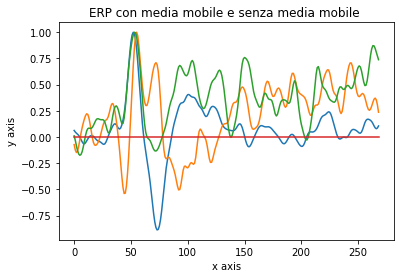

In [70]:
plt.plot(range(269),ERP_ROI_Uomini_vector[0]) 
plt.plot(range(269),ERP_ROI_Uomini_vector[1])
plt.plot(range(269),ERP_ROI_Uomini_vector[2]) 
plt.plot(range(269),ERP_ROI_Uomini_vector[3])
# Add Title

plt.title("ERP con media mobile e senza media mobile ") 

# Add Axes Labels

plt.xlabel("x axis") 
plt.ylabel("y axis") 

# Display

plt.show()

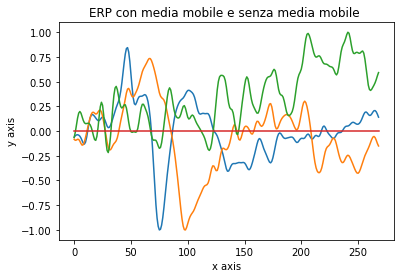

In [72]:
plt.plot(range(269),ERP_ROI_Animali_vector[0]) 
plt.plot(range(269),ERP_ROI_Animali_vector[1])
plt.plot(range(269),ERP_ROI_Animali_vector[2]) 
plt.plot(range(269),ERP_ROI_Animali_vector[3])
# Add Title

plt.title("ERP con media mobile e senza media mobile ") 

# Add Axes Labels

plt.xlabel("x axis") 
plt.ylabel("y axis") 

# Display

plt.show()